In [50]:
import sys
import pandas as pd
import numpy as np
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [4]:
# кластеризатор
class MaxminMethod:
    def __init__(self, X_set):
        self.X_set = X_set
        self.clusters = []
        # метрика (евклидова)
        self.metric_func = lambda x, y: np.sqrt(((x - y) ** 2).sum())

    # поулчаем кластеры с объектами
    def get_clusters(self):
        result = {}
        for cluster in self.clusters:
            result[cluster['obj_prototype_idx']] = []
        for obj_idx in self.X_set.index:
            min_dist = sys.float_info.max
            obj_prototype_idx = -1
            for cluster in self.clusters:
                dist = cluster['dist'][obj_idx]
                if dist < min_dist:
                    min_dist = cluster['dist'][obj_idx]
                    obj_prototype_idx = cluster['obj_prototype_idx']
            result[obj_prototype_idx].append(obj_idx)
        return result

    # запуск алгоритма
    def start(self):
        self.clusters.clear()
        self.clusters.append({
            'obj_prototype_idx': 0,
            'dist': self.get_series_of_dist_to_obj(self.X_set.loc[0])
        })
        while True:
            prototype_obj_idx, max_dist = self.find_next_possible_prototype()
            if max_dist <= self.get_average_dist_of_clusters():
                break
            self.clusters.append({
                'obj_prototype_idx': prototype_obj_idx,
                'dist': self.get_series_of_dist_to_obj(self.X_set.loc[prototype_obj_idx])
            })

    # находим половину среднего арифметического всех расстояний между прототипами
    def get_average_dist_of_clusters(self):
        sum = 0.0
        count = 0
        for i in range(0, len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                obj_prototype_idx = self.clusters[j]['obj_prototype_idx']
                sum = sum + self.clusters[i]['dist'][obj_prototype_idx]
                count = count + 1
        if count == 0:
            return 0.0
        return sum / (2 * count)

    # найти следующий потенциальный прототип
    def find_next_possible_prototype(self):
        max_dist = 0.0
        prototype_obj_idx = -1
        for obj_idx in self.X_set.index:
            min_dist = sys.float_info.max
            for cluster in self.clusters:
                dist = cluster['dist'][obj_idx]
                if dist < min_dist:
                    min_dist = cluster['dist'][obj_idx]
            if min_dist > max_dist:
                max_dist = min_dist
                prototype_obj_idx = obj_idx
        return prototype_obj_idx, max_dist

    # поулчить серию расстояний от всех объектов до данного
    def get_series_of_dist_to_obj(self, obj):
        return self.X_set.apply(lambda row: self.metric_func(row, obj), axis=1)

In [5]:
# кластеризатор
class KMeansMethod:
    def __init__(self, X_set, cluster_count):
        self.X_set = X_set
        self.cluster_count = cluster_count
        self.clusters = []
        # метрика (евклидова)
        self.metric_func = lambda x, y: ((x - y) ** 2).sum()
        self.delta_eps = 0.01 * 0.01

    # поулчаем кластеры с объектами
    def get_clusters(self, indexes=True):
        cluster_objs = {}
        for obj_idx, obj in self.X_set.iterrows():
            min_dist = sys.float_info.max
            cluster_idx = -1
            for (i, prototype_obj) in enumerate(self.clusters):
                dist = self.metric_func(obj, prototype_obj)
                if dist < min_dist:
                    min_dist = dist
                    cluster_idx = i
            if indexes:
                cluster_objs.setdefault(cluster_idx, []).append(obj_idx)
            else:
                cluster_objs.setdefault(cluster_idx, []).append(obj)
        return cluster_objs

    # запуск алгоритма
    def start(self):
        self.clusters.clear()
        for i in range(0, self.cluster_count):
            self.clusters.append(self.X_set.loc[i])

        while True:
            cluster_objs = self.get_clusters(False)
            end = True
            for cluster_idx, objs in cluster_objs.items():
                df = pd.DataFrame(objs)
                mean_val = df.mean()
                if self.metric_func(self.clusters[cluster_idx], mean_val) >= self.delta_eps:
                    self.clusters[cluster_idx] = mean_val
                    end = False
            if end:
                break

In [68]:
# классификатор
class KNearestNeighbors:
    def __init__(self, k):
        self.k = k
        self.metric_func = lambda x, y: ((x - y) ** 2).sum()
        
    def train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, sample):
        indexes = self.X_train.apply(lambda row: self.metric_func(row, sample), axis=1).to_frame().sort_values(0).head(self.k).index
        return self.y_train[indexes].value_counts().idxmax()

    def predict_test_set(self, X_test):
        return X_test.apply(lambda row: self.predict(row), axis=1)

In [69]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0], a.shape[1] + 1))
    a_extended[:, :-1] = a
    a_extended[:, -1] = 1.
    return a_extended


# классификатор
class SVM:
    def __init__(self):
        self.w = None

    def train(self, X_train, y_train, epoches_count=1000, batch_size=20, alpha=0.1):
        # создаем вектор весов, расширяя пространство на 1
        self.w = torch.rand([X_train.shape[1] + 1, 1], requires_grad=True)

        # стохастический градиентный спуск
        optimizer = torch.optim.SGD([self.w], lr=0.001)
        for epoch in range(epoches_count):
            # перемешиваем индексы
            order = np.random.permutation(len(X_train))
            sum_loss = 0
            for start_index in range(0, len(X_train), batch_size):
                optimizer.zero_grad()
                # формируем батч
                batch_indexes = order[start_index:start_index + batch_size]
                X_batch = torch.tensor(add_bias_feature(X_train.iloc[batch_indexes].values).astype(np.float32))
                y_batch = torch.tensor(y_train.iloc[batch_indexes].values.astype(np.float32)).unsqueeze(1)

                # построение графа вычислений для функции потерь SVM
                loss_val = torch.clamp(1. - y_batch * X_batch @ self.w, min=0)
                loss_val = loss_val.mean() + alpha * self.w.t() @ self.w / 2.

                # нахождение градиента
                loss_val.backward()
                optimizer.step()
                sum_loss += float(loss_val)
            #predicted = self.predict_test_set(X_test)
            #accuracy = (y_test == predicted).mean()
            #print(f'accuracy = {accuracy}, sum_loss = {sum_loss}')

    def predict(self, sample):
        x = sample.values
        x = np.append(x, 1.)
        label = self.w.t() @ torch.tensor(x.astype(np.float32))
        return np.sign(label.item())

    def predict_test_set(self, X_test):
        return X_test.apply(lambda row: self.predict(row), axis=1)

In [56]:
# загружаем множество объектов
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target).map(lambda label: -1.0 if label == 2 else 1.0)
# положительный класс имеет метку 1.0

In [57]:
maxmin_method = MaxminMethod(X)
maxmin_method.start()
clusters1 = maxmin_method.get_clusters()

k_means_method = KMeansMethod(X, 3)
k_means_method.start()
clusters2 = k_means_method.get_clusters()

In [75]:
# делим множество на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

classifier1 = KNearestNeighbors(5)
classifier1.train(X_train, y_train)
predicted1 = classifier1.predict_test_set(X_test)

classifier2 = SVM()
classifier2.train(X_train, y_train)
predicted2 = classifier2.predict_test_set(X_test)

In [88]:
def estimate_clf(y_test, predicted):
    TP = ((y_test == 1.0) & (predicted == 1.0)).sum()
    TN = ((y_test == -1.0) & (predicted == -1.0)).sum()
    FP = ((y_test == -1.0) & (predicted == 1.0)).sum()
    FN = ((y_test == 1.0) & (predicted == -1.0)).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    MSE = (y_test - predicted).pow(2).mean()
    print(f'1) точность = {precision}, полнота = {recall}, F1-мера = {f1}')
    print(f'2) ROC-кривая')
    fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print(f'3) MSE = {MSE}')
    print(f'4) матрица неточности:\n{TN} | {FN}\n{FP} | {TP}')

In [89]:
def cross_validation(clf, X, y, k=5):
    order = np.random.permutation(X.index)
    part_size = len(X) // k
    total_accuracy = 0.0
    for start_index in range(0, len(order), part_size):
        train_indexes = np.hstack([order[:start_index], order[start_index + part_size:]])
        test_indexes = order[start_index:start_index + part_size]
        clf.train(X.loc[train_indexes], y[train_indexes])
        predicted = clf.predict_test_set(X.loc[test_indexes])
        accuracy = (y[test_indexes] == predicted).mean()
        total_accuracy += accuracy
    return total_accuracy / k

KNearestNeighbors
1) точность = 1.0, полнота = 0.8888888888888888, F1-мера = 0.9411764705882353
2) ROC-кривая


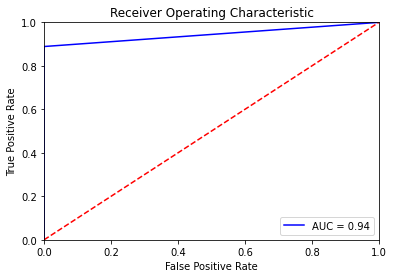

3) MSE = 0.26666666666666666
4) матрица неточности:
6 | 1
0 | 8
5) Кросс-валидация = 0.9666666666666668


In [90]:
print('KNearestNeighbors')
estimate_clf(y_test, predicted1)
accuracy = cross_validation(classifier1, X, y)
print(f'5) Кросс-валидация = {accuracy}')

SVM
1) точность = 1.0, полнота = 0.7777777777777778, F1-мера = 0.8750000000000001
2) ROC-кривая


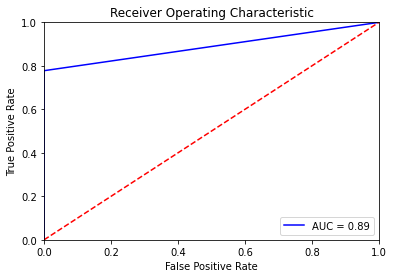

3) MSE = 0.5333333333333333
4) матрица неточности:
6 | 2
0 | 7
5) Кросс-валидация = 0.9533333333333334


In [91]:
print('SVM')
estimate_clf(y_test, predicted2)
accuracy = cross_validation(classifier2, X, y)
print(f'5) Кросс-валидация = {accuracy}')

In [165]:
df = pd.DataFrame(np.random.randn(5, 3),columns=['x1', 'x2', 'x3'])
df['cluster'] = pd.Series([1,1,2,6,6])
df

,x1,x2,x3,cluster
0,-1.077025,-1.266896,-0.616675,1
1,-0.430467,-0.659645,-0.024909,1
2,0.368813,1.716952,0.430061,2
3,0.953682,-1.034902,0.782635,6
4,-0.857504,-0.835224,-0.428616,6


In [166]:
df.groupby('cluster').apply(lambda objs: objs.mean())

,x1,x2,x3
cluster,,,
1,-0.753746,-0.963270,-0.320792
2,0.368813,1.716952,0.430061
6,0.048089,-0.935063,0.177009


In [146]:
def to_df(clusters):
    result = None
    for k, v in clusters.items():
        df = X.loc[v].copy()
        df['cluster'] = k
        result = pd.concat([result, df])
    return result

In [131]:
def CoefficientOfDetermination(df):
    all_objs = df.drop('cluster', axis=1)
    global_center = all_objs.mean()
    SSB = 0.0
    SST = all_objs.apply(
        lambda obj: ((obj - global_center) ** 2).sum(), axis=1).sum()
    for cluster_idx in df.cluster.unique():
        cluster_objs = df[df.cluster == cluster_idx].drop('cluster', axis=1)
        cluster_center = cluster_objs.mean()
        SSB += cluster_objs.apply(
            lambda obj: ((obj - cluster_center) ** 2).sum(), axis=1).sum()
    return 1.0 - SSB / SST

In [178]:
def Silhouette(df):
    def get_nearest_cluster(obj):
        return df[df.cluster != obj.cluster].groupby('cluster').apply(
            lambda objs: np.linalg.norm(objs.mean()[:-1] - obj[:-1])).sort_values(0).index[0]
    def calc_a(obj):
        return df[df.cluster == obj.cluster].apply(
            lambda obj2: np.linalg.norm((obj - obj2).values), axis=1).mean()
    def calc_b(obj, nearest_cluster):
        return df[df.cluster == nearest_cluster].apply(
            lambda obj2: np.linalg.norm((obj - obj2).values), axis=1).mean()
    calc = lambda a, b: (b - a) / max(a, b)
    return df.apply(
        lambda obj: calc(calc_a(obj), calc_b(obj, get_nearest_cluster(obj))), axis=1).mean()

In [177]:
# check
df[df.cluster == 6].apply(
            lambda obj2: np.linalg.norm((df.loc[1,:] - obj2).values), axis=1).mean()

5.150696261531362

In [167]:
def estimate_clst(clusters):
    df = to_df(clusters)
    Rsq = CoefficientOfDetermination(df)
    Sil = Silhouette(df)
    print(f'1. Коэффициент детерминации = {Rsq}')
    print(f'2. Коэффициент силуэта = {Sil}')

In [179]:
print('MaxminMethod')
estimate_clst(clusters1)

MaxminMethod
1. Коэффициент детерминации = 0.8754015709670973
2. Коэффициент силуэта = 0.9466922224101694


In [180]:
print('KMeansMethod')
estimate_clst(clusters2)

KMeansMethod
1. Коэффициент детерминации = 0.8842690514883129
2. Коэффициент силуэта = 0.6195922556510821
